In [1]:
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import random
import networkx as nx
import numpy as np

from bamt.Preprocessors import Preprocessor
from bamt.ScoringFunctions import BICGMM, BICGauss, BIC_local, BIC_local_gauss
from bamt.mi_entropy_gauss import mi_gauss
import bamt.Networks as Nets
from pgmpy.estimators import K2Score, BicScore
from pgmpy.estimators import HillClimbSearch
import networkx as nx
from bamt.utils.MathUtils import *
from gmr import GMM
from sklearn.metrics import mean_squared_error
from copy import copy
from pgmpy.models import BayesianNetwork

KeyboardInterrupt: 

In [ ]:
def gmm_kl_sklearn (gmm_p, gmm_q, n = 10**5):
    X = gmm_p.sample(n)[0]
    log_p = gmm_p.score_samples(X)
    log_q = gmm_q.score_samples(X)
    return log_p.mean() - log_q.mean()

In [ ]:
def gmm_js_sklearn(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return (log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2

In [ ]:
def child_dict(net: list):
    res_dict = dict()
    for e0, e1 in net:
        if e1 in res_dict:
            res_dict[e1].append(e0)
        else:
            res_dict[e1] = [e0]
    return res_dict

def precision_recall(pred_net: list, true_net: list, decimal = 2):
    pred_dict = child_dict(pred_net)
    true_dict = child_dict(true_net)
    corr_undir = 0
    corr_dir = 0
    for e0, e1 in pred_net:
        flag = True
        if e1 in true_dict:
            if e0 in true_dict[e1]:
                corr_undir += 1
                corr_dir += 1
                flag = False
        if (e0 in true_dict) and flag:
            if e1 in true_dict[e0]:
                corr_undir += 1
    pred_len = len(pred_net)
    true_len = len(true_net)
    shd = pred_len + true_len - corr_undir - corr_dir
    return {'SHD': shd}
    # return {'AP': round(corr_undir/pred_len, decimal), 'AR': round(corr_undir/true_len, decimal), 'AHP': round(corr_dir/pred_len, decimal), 'AHR': round(corr_dir/true_len, decimal), 'SHD': shd}


In [ ]:
data = pd.read_csv('../data/hack_processed_with_rf.csv')
data

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/offshore,...,Period,Lithology,Gross,Netpay,Porosity,Permeability,Oil density,Oil recovery factor,Condensate recovery factor,Gas recovery factor
0,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,...,JURASSIC,LIMESTONE,75.0,55.2,21.0,410.0,839.762611,NaN,NaN,NaN
1,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,EXTENSION,29.7422,28.4925,GUPCO,ONSHORE,...,CRETACEOUS,SANDSTONE,223.5,43.2,10.0,8.0,NaN,NaN,NaN,0.84
2,ABU MADI-EL QARA,ABU MADI (LEVEL II),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,...,NEOGENE,THINLY-BEDDED SANDSTONE,34.5,19.8,22.0,200.0,NaN,NaN,NaN,0.75
3,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,...,NEOGENE,SANDSTONE,152.7,123.0,20.0,300.0,779.614325,NaN,NaN,0.78
4,AL HUWAISAH,SHUAIBA,OMAN,MIDDLE EAST,FAHUD SALT,COMPRESSION,21.9607,56.0452,PDO,ONSHORE,...,CRETACEOUS,LIMESTONE,75.0,30.0,21.0,60.0,825.072886,0.26,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,ZAOYUAN,KONGDIAN-1 (ZILAITUN BLOCK),CHINA,FAR EAST,BOHAI,EXTENSION,38.2100,117.0600,PETROCHINA,ONSHORE,...,PALEOGENE,SANDSTONE,49.2,18.6,23.2,121.0,946.488294,0.13,NaN,NaN
510,ZAOYUAN,KONGDIAN-2 (FENGHUADIAN BLOCK),CHINA,FAR EAST,BOHAI,NaN,38.2100,117.0600,PETROCHINA,ONSHORE,...,PALEOGENE,SANDSTONE,88.5,23.7,NaN,60.0,881.619938,0.19,NaN,NaN
511,ZAOYUAN,UNNAMED (FENGHUADIAN BLOCK),CHINA,FAR EAST,BOHAI,EXTENSION,38.2100,117.0600,PETROCHINA,ONSHORE,...,MESOZOIC,VOLCANICS,147.6,58.2,12.7,3.6,870.769231,0.05,NaN,NaN
512,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,...,CARBONIFEROUS,SANDSTONE,78.6,9.9,24.0,30.0,887.147335,0.24,NaN,NaN


In [ ]:
cols = ['Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[cols]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [ ]:

discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
coder = preprocessing.LabelEncoder()
p = Preprocessor([])
discretized_data, est = p.apply(data)
#discretized_data, est = p.discretize(data, discretizer)

2022-07-22 16:39:33,786 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [ ]:
bn_gmm = Nets.ContinuousBN(use_mixture=True)
bn_g = Nets.ContinuousBN(use_mixture=False)
bn_g.add_nodes(p.info)
bn_gmm.add_nodes(p.info)

bn_gmm.add_edges(data, scoring_function=('K2', BICGMM), params={'epsilon':0.0001})
#bn_g.add_edges(data, scoring_function=('BIC', ))

  0%|          | 4/1000000 [00:54<3809:09:53, 13.71s/it]


In [ ]:
bn_gmm.edges

[['Gross', 'Permeability'],
 ['Netpay', 'Porosity'],
 ['Netpay', 'Gross'],
 ['Depth', 'Netpay']]

In [ ]:
par = [1, 2]
#cond_m = [3]*data.shape[0] + ([par]*data.shape[0])*(data[['Gross', 'Netpay']].values)
np.sum(([par]*data.shape[0])*(data[['Gross', 'Netpay']].values), axis=1)


array([ 185.4,  309.9,   74.1,  398.7,  135. ,   37.5,  153. ,  246.9,
         44.4, 2745. ,  472.2,  567.9,   51.6,  382.5,   60. ,   66. ,
        201. ,  795.6,   78. ,  516.9,  531. ,  232.2,  236.1,  798. ,
         27. ,  897. ,   62.1,  199.8,  197.1,  681. ,  155.7,  441. ,
        217.5,   78. ,   95.4,   52.2,  217.5,  567. ,   58.8,  290.1,
         48. ,  690. ,   27.3,  195. ,  405. ,  162. ,  140.4,  883.2,
         40.8,   22.2,   88.6, 1290. , 1092. ,  373.8,  125.4,   86.1,
        142.8,  232.5,  147. ,  102. ,  154.5,  300. ,  156. ,  138. ,
       2694. ,  174. ,   87.9,  550.8,  146.1,  324. ,   94.2,  126. ,
         56.4,  810. ,  540. ,   84. ,  199.5,  162. , 1710. ,   99.6,
        165. ,  175.8,   38.7,   17.4,   10.2,  114.3, 2364. ,  425.1,
        321. ,   99. ,  562.5,  429. ,  324. ,   32.1,   29.6,   27.6,
         45.6,  240. ,  300. ,  246. ,  240. ,  384. ,   49.8,   93. ,
         76.5,  188.4, 3198. ,  382.8,   72.6,   69.6,   34.2,  141.3,
      

In [ ]:
bn_gmm.fit_parameters(data)
sample1 = bn_gmm.sample(500)
sample1 = sample1[(sample1 > 0).all(1)]

NameError: name 'bn_gmm' is not defined

In [ ]:
bn_g.fit_parameters(data)
sample2 = bn_g.sample(500)
sample2 = sample2[(sample2 > 0).all(1)]

100%|██████████| 500/500 [00:00<00:00, 33421.28it/s]


In [ ]:
discretizer = preprocessing.LabelEncoder()

p1 = Preprocessor([('discretizer', discretizer)])
discrete, est = p1.apply(discretized_data)

2022-07-21 16:47:44,866 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


ValueError: y should be a 1d array, got an array of shape (442, 5) instead.

In [ ]:
bn_d = Nets.DiscreteBN()
bn_d.add_nodes(p1.info)
bn_d.add_edges(discrete, scoring_function=('K2',BicScore))

  0%|          | 2/1000000 [00:00<25:08:26, 11.05it/s]


In [ ]:
bn_d.fit_parameters(discrete)

In [ ]:
sample = bn_d.sample(500)
sample = sample[['Gross','Netpay','Porosity','Permeability', 'Depth', 'NTG']]

In [ ]:
sample_cont = pd.DataFrame(est.inverse_transform(sample.values), columns=['Gross','Netpay','Porosity','Permeability', 'Depth', 'NTG'])

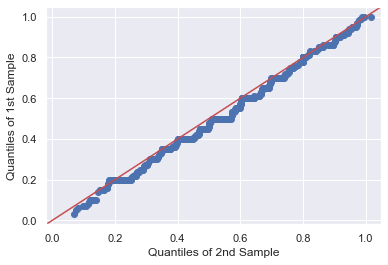

In [ ]:
sns.set(style="darkgrid")
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
pp_x = sm.ProbPlot(data['NTG'].values)
pp_y = sm.ProbPlot(sample1['NTG'].values)
qqplot_2samples(pp_x, pp_y, line='45')
plt.show()

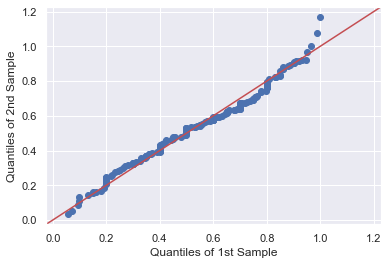

In [ ]:
pp_y = sm.ProbPlot(sample2['NTG'].values)
qqplot_2samples(pp_x, pp_y, line='45')
plt.show()

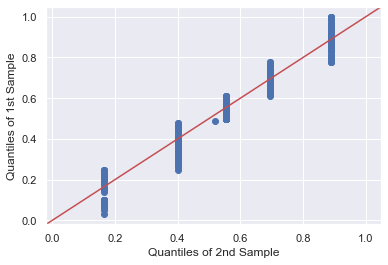

In [ ]:
pp_y = sm.ProbPlot(sample_cont['NTG'].values)
qqplot_2samples(pp_x, pp_y, line='45')
plt.show()

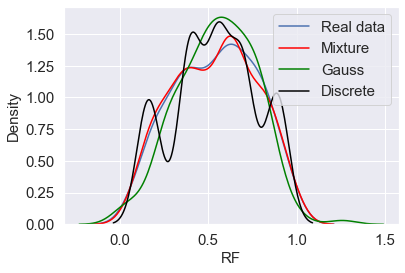

In [ ]:
sns.set(style="darkgrid")
sns.distplot(data['NTG'], hist=False, label='Real data')
sns.distplot(sample1['NTG'], hist=False, color='Red', label='Mixture')
sns.distplot(sample2['NTG'], hist=False, color='Green', label='Gauss')
sns.distplot(sample_cont['NTG'], hist=False, color='Black', label='Discrete')
plt.tick_params(labelsize=15)
plt.xlabel('RF', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(fontsize=15)
plt.savefig("RF.pdf", format="pdf", bbox_inches="tight", facecolor='w')


In [ ]:
bn_g.add_edges(data, scoring_function=('K2', BICGauss))
bn_g.fit_parameters(data)

  0%|          | 8/1000000 [00:36<1250:17:51,  4.50s/it]


In [ ]:
sample = bn_g.sample(500)
sample = sample[(sample > 0).all(1)]

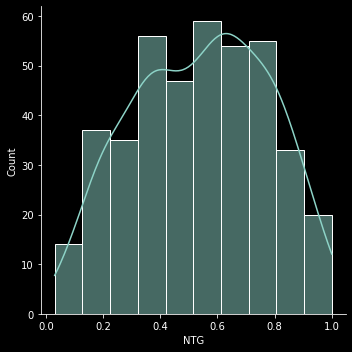

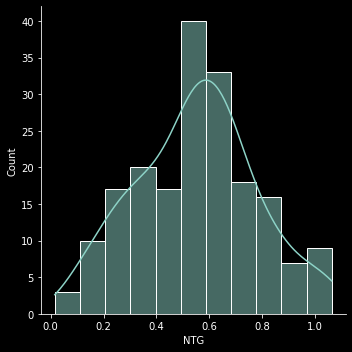

In [ ]:
sns.displot(data['NTG'], kde=True)
sns.displot(sample['NTG'], kde=True)

In [ ]:
with open('true_geo.txt') as f:
    lines = f.readlines()
true_net = []
for l in lines:
    e0 = l.split()[0]
    e1 = l.split()[1].split('\n')[0]
    true_net.append((e0, e1))

In [ ]:
precision_recall(bn_gmm.edges, true_net)

{'AP': 0.7, 'AR': 0.64, 'AHP': 0.3, 'AHR': 0.27, 'SHD': 11}

In [ ]:
bn_gmm.fit_parameters(data)
bn_g.fit_parameters(data)

In [ ]:
med = pd.read_csv('../Data/medicine.csv')
med

,total_bilirubin_mean,triglycerides_mean,creatinine_mean,potassium_mean,AST_mean,ALT_mean,sodium_mean,total_protein_mean,HDL_mean,hba1c_mean,...,diabetic_angiopathy,diabetic_nephropathy,neuropathy,cushing_syndrome,stroke,insulins,all_gipoglemic_drugs,all_statins,diuretic,beta_block
0,11.738543,0.670000,137.00,4.500000,28.000000,28.000000,140.000000,67.200000,0.950000,8.667665,...,1.0,1.0,1.0,0.0,0.0,1,0,1,1,1
1,27.585625,1.720000,86.00,4.586997,25.500000,29.300000,140.393094,71.245188,1.250000,8.066571,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1
2,25.028889,1.965000,86.00,4.412873,23.550000,31.650000,140.322773,71.333872,1.400000,7.934365,...,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1
3,24.283750,1.806667,91.00,4.384852,21.066667,30.300000,140.850019,70.453878,1.330000,6.106401,...,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1
4,24.173043,1.406667,96.00,4.507934,18.850000,30.800000,140.989590,69.446380,1.383333,6.106401,...,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,5.700000,0.760000,66.00,4.720000,11.600000,14.400000,142.000000,78.400000,1.280000,8.106455,...,1.0,0.0,0.0,0.0,0.0,0,1,1,0,0
876,6.800000,2.040000,81.00,5.290000,26.787070,31.472158,143.000000,73.600000,1.220000,10.806466,...,1.0,1.0,1.0,0.0,1.0,1,1,0,1,1
877,6.800000,2.040000,81.50,5.350000,27.158420,29.483380,144.500000,73.600000,1.220000,10.806466,...,1.0,1.0,1.0,0.0,1.0,1,1,0,1,1
878,5.220000,1.760000,80.50,5.350000,21.200000,24.700000,144.500000,75.105000,1.303333,10.381475,...,1.0,1.0,1.0,0.0,1.0,1,1,1,1,1


In [ ]:
for c in med.columns:
    med[c] = med[c].apply(lambda x:  int(x) if len(str(x)) == 3 else x)

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = Preprocessor([('discretizer', discretizer)])
discretized_data, est = p.apply(med)


In [ ]:
cont_nodes = list(p.info['signs'].keys())

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = Preprocessor([('discretizer', discretizer)])
discretized_data, est = p.apply(med[cont_nodes])
discretized_data, est = p.discretize(med[cont_nodes], discretizer)

2022-04-27 13:01:24,428 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [ ]:
med = med[cont_nodes]
med.dropna(inplace=True)
med.reset_index(inplace=True, drop=True)

In [ ]:
bn_gmm = Nets.ContinuousBN(use_mixture=True)
bn_g = Nets.ContinuousBN(use_mixture=False)
bn_g.add_nodes(p.info)
bn_gmm.add_nodes(p.info)
params1 = {'epsilon': 0.0001, 'tabu':200}


bn_gmm.add_edges(discretized_data, scoring_function=('K2', BicScore), params=params1)
bn_g.add_edges(med, scoring_function=('BIC', ))

  0%|          | 11/1000000 [00:02<64:33:28,  4.30it/s]


[643.4792928004377, 463.5435578095247, 287.1138324034566, 174.04548537606138, 164.28835705112147, 159.31262534650523, 186.0673156514797, 8.519034719400452, 6.802055593095247, 2.1612173644509767, 0.9824257760176351, 0.0]
---------------------


In [ ]:
bn_gmm.fit_parameters(med)
sample1 = bn_gmm.sample(800)
sample1 = sample1[(sample1 > 0).all(1)]

bn_g.fit_parameters(med)
sample2 = bn_g.sample(800)
sample2 = sample2[(sample2 > 0).all(1)]

In [ ]:
sample1.to_csv('med_d_gmm_sample.csv', index=False)

In [ ]:
sample2.to_csv('med_g_sample.csv', index=False)

In [ ]:
discretized_data, est = p.discretize(med, discretizer)

In [ ]:
discretizer = preprocessing.LabelEncoder()

p1 = Preprocessor([('discretizer', discretizer)])
discrete, est = p1.apply(discretized_data)

2022-04-26 21:51:12,813 | INFO     | Preprocessors.py-scan-0087 | No one column is continuous


In [ ]:
bn_d = Nets.DiscreteBN()
bn_d.add_nodes(p1.info)
params2 = {'epsilon': 0.0001, 'tabu':2000}
bn_d.add_edges(discrete, scoring_function=('K2',BicScore), params=params2)

bn_d.fit_parameters(discrete)

  0%|          | 11/1000000 [00:02<72:38:43,  3.82it/s]

[643.4792928004377, 463.5435578095247, 287.1138324034566, 174.04548537606138, 164.28835705112147, 159.31262534650523, 186.0673156514797, 8.519034719400452, 6.802055593095247, 2.1612173644509767, 0.9824257760176351, 0.0]
---------------------


In [ ]:
name = cont_nodes[2]
name

'creatinine_mean'

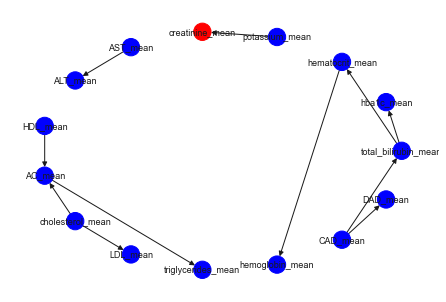

In [ ]:
import networkx as nx
sns.set(style="darkgrid")
color_map = []
graph = nx.DiGraph()
graph.add_edges_from(bn_d.edges)
for n in graph.nodes:
    if n == name:
        color_map.append('red')
    else:
        color_map.append('blue')
nx.draw(graph, node_color=color_map, with_labels=True, pos=nx.circular_layout(graph), font_size=9, cmap='tab10')
plt.savefig('discrete_med_graph.pdf', dpi=300, bbox_inches='tight', facecolor='white')

In [ ]:
sample = bn_d.sample(800)
sample = sample[cont_nodes]

In [ ]:
sample_cont = pd.DataFrame(est.inverse_transform(sample.values), columns=cont_nodes)

In [ ]:
sample_cont.to_csv('discrete_med_sample.csv', index=False)

In [ ]:
data = copy(med)

In [ ]:
name = cont_nodes[2]
name

'creatinine_mean'

In [ ]:
sample1 = pd.read_csv('med_gmm_sample.csv')
sample2 = pd.read_csv('med_g_sample.csv')
sample_cont = pd.read_csv('discrete_med_sample.csv')
sample3 = pd.read_csv('med_d_gmm_sample.csv')


In [ ]:
import scipy.stats as stats 
from math import sqrt 
def conf_intervals(data, qn):
    # 95% quantile of Gaussian distribution
    norm_q95 = stats.norm.ppf(0.95)
    kernel = stats.gaussian_kde(data)

    p25 = len(data[data < qn[5]]) / len(data)
    sigma25 = \
        (sqrt((p25 * (1 - p25)) / len(data))) / kernel(qn[5])
    p50 = len(data[data < qn[10]]) / len(data)
    sigma50 = \
        (sqrt((p50 * (1 - p50)) / len(data))) / kernel(qn[10])
    p75 = len(data[data < qn[15]]) / len(data)
    sigma75 = \
        (sqrt((p75 * (1 - p75)) / len(data))) / kernel(qn[15])

    conf_q25 = norm_q95 * sigma25
    conf_q50 = norm_q95 * sigma50
    conf_q75 = norm_q95 * sigma75

    return [conf_q25, conf_q50, conf_q75]

In [ ]:


# Расчет квантилей
percs = np.linspace(0, 100, 19)
qn_first = np.percentile(data[name], percs)
qn_second = np.percentile(sample1[name], percs)

conf_first = conf_intervals(data[name], qn_first)
conf_second = conf_intervals(sample1[name], qn_first)



qn_first1 = np.percentile(data[name], percs)
qn_second1 = np.percentile(sample2[name], percs)

conf_first1 = conf_intervals(data[name], qn_first1)
conf_second1 = conf_intervals(sample2[name], qn_first1)


qn_first2 = np.percentile(data[name], percs)
qn_second2 = np.percentile(sample_cont[name], percs)

conf_first2 = conf_intervals(data[name], qn_first2)
conf_second2 = conf_intervals(sample_cont[name], qn_first2)



qn_first3 = np.percentile(data[name], percs)
qn_second3 = np.percentile(sample3[name], percs)

conf_first3 = conf_intervals(data[name], qn_first3)
conf_second3 = conf_intervals(sample3[name], qn_first3)

In [ ]:
conf_first_list = []
conf_second_list = []
for element1, element2 in zip(conf_first, conf_second):
    conf_first_list.append(element1[0])
    conf_second_list.append(element2[0])



conf_first_list1 = []
conf_second_list1 = []
for element1, element2 in zip(conf_first1, conf_second1):
    conf_first_list1.append(element1[0])
    conf_second_list1.append(element2[0])

conf_first_list2 = []
conf_second_list2 = []
for element1, element2 in zip(conf_first2, conf_second2):
    conf_first_list2.append(element1[0])
    conf_second_list2.append(element2[0])



conf_first_list3 = []
conf_second_list3 = []
for element1, element2 in zip(conf_first3, conf_second3):
    conf_first_list3.append(element1[0])
    conf_second_list3.append(element2[0])

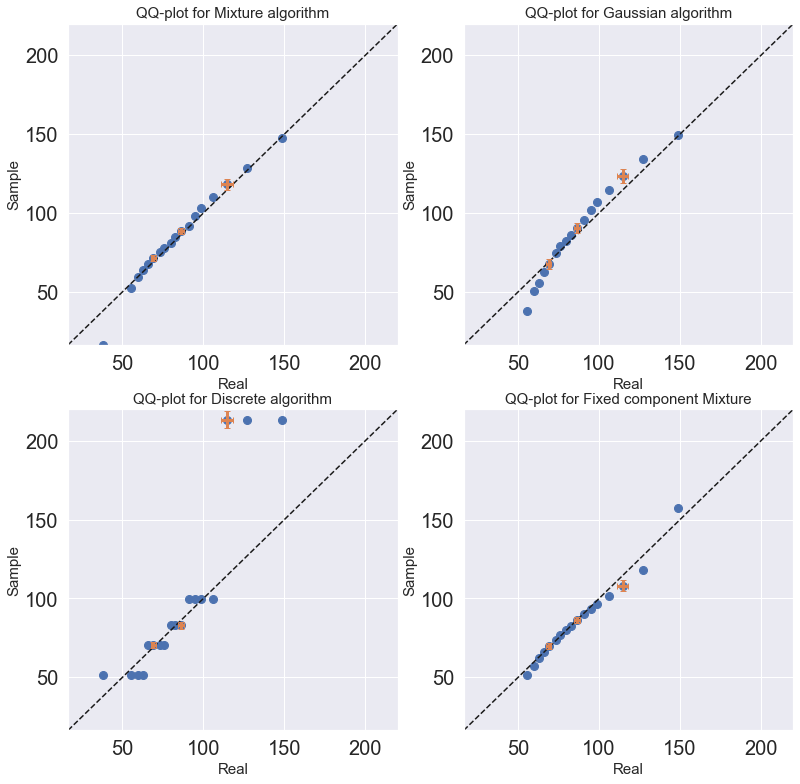

In [ ]:
# Построение квантильного биплота для двух случайных величин
sns.set(style="darkgrid")
fig, ax = plt.subplots(2, 2, figsize=(13,13))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

ax[0,0].plot(qn_first, qn_second, ls="", marker="o", markersize=8)
ax[0,0].plot(x, x, color="k", ls="--")
ax[0,0].set_xlabel('Real', fontsize=15)
ax[0,0].set_ylabel('Sample', fontsize=15)
ax[0,0].set_xlim([min_qn, 220])
ax[0,0].set_ylim([min_qn, 220])
ax[0,0].grid(True)
ax[0,0].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[0,0].errorbar(
    # [25%, 50%, 75%]
    [qn_first[5], qn_first[10], qn_first[15]],
    [qn_second[5], qn_second[10], qn_second[15]],
    xerr=conf_first_list,
    yerr=conf_second_list,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[0,0].set_title('QQ-plot for Mixture algorithm', fontsize=15)



ax[0,1].plot(qn_first1, qn_second1, ls="", marker="o", markersize=8)
ax[0,1].plot(x, x, color="k", ls="--")
ax[0,1].set_xlabel('Real', fontsize=15)
ax[0,1].set_ylabel('Sample', fontsize=15)
ax[0,1].set_xlim([min_qn, 220])
ax[0,1].set_ylim([min_qn, 220])
ax[0,1].grid(True)
ax[0,1].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[0,1].errorbar(
    # [25%, 50%, 75%]
    [qn_first1[5], qn_first1[10], qn_first1[15]],
    [qn_second1[5], qn_second1[10], qn_second1[15]],
    xerr=conf_first_list1,
    yerr=conf_second_list1,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[0,1].set_title('QQ-plot for Gaussian algorithm', fontsize=15)


ax[1,0].plot(qn_first2, qn_second2, ls="", marker="o", markersize=8)
ax[1,0].plot(x, x, color="k", ls="--")
ax[1,0].set_xlabel('Real', fontsize=15)
ax[1,0].set_ylabel('Sample', fontsize=15)
ax[1,0].set_xlim([min_qn, 220])
ax[1,0].set_ylim([min_qn, 220])
ax[1,0].grid(True)
ax[1,0].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[1,0].errorbar(
    # [25%, 50%, 75%]
    [qn_first2[5], qn_first2[10], qn_first2[15]],
    [qn_second2[5], qn_second2[10], qn_second2[15]],
    xerr=conf_first_list2,
    yerr=conf_second_list2,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[1,0].set_title('QQ-plot for Discrete algorithm', fontsize=15)



ax[1,1].plot(qn_first3, qn_second3, ls="", marker="o", markersize=8)
ax[1,1].plot(x, x, color="k", ls="--")
ax[1,1].set_xlabel('Real', fontsize=15)
ax[1,1].set_ylabel('Sample', fontsize=15)
ax[1,1].set_xlim([min_qn, 220])
ax[1,1].set_ylim([min_qn, 220])
ax[1,1].grid(True)
ax[1,1].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[1,1].errorbar(
    # [25%, 50%, 75%]
    [qn_first3[5], qn_first3[10], qn_first3[15]],
    [qn_second3[5], qn_second3[10], qn_second3[15]],
    xerr=conf_first_list3,
    yerr=conf_second_list3,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[1,1].set_title('QQ-plot for Fixed component Mixture', fontsize=15)
plt.savefig("med_all.pdf", format="pdf", bbox_inches="tight", facecolor='white')

In [ ]:
data = pd.read_csv('faithful.csv')
data = data.drop(columns=['Unnamed: 0'])
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
data = data.astype(float)

In [ ]:
name = 'eruptions'#'waiting'	

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = Preprocessor([('discretizer', discretizer)])
discretized_data, est = p.apply(data)

2022-04-27 13:30:53,107 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [ ]:
bn_gmm = Nets.ContinuousBN(use_mixture=True)
bn_g = Nets.ContinuousBN(use_mixture=False)
bn_g.add_nodes(p.info)
bn_gmm.add_nodes(p.info)
params1 = {'epsilon': 0.0001, 'tabu':200}
bn_gmm.add_edges(discretized_data, scoring_function=('K2', BicScore), params=params1)
bn_g.add_edges(data, scoring_function=('BIC', ))

  0%|          | 1/1000000 [00:00<4:10:00, 66.67it/s]


[107.12894094450331, -5.684341886080802e-14]
---------------------


In [ ]:
bn_gmm.fit_parameters(data)
sample1 = bn_gmm.sample(200)
sample1 = sample1[(sample1 > 0).all(1)]

bn_g.fit_parameters(data)
sample2 = bn_g.sample(200)
sample2 = sample2[(sample2 > 0).all(1)]

In [ ]:
sample1.to_csv('gmm_d_erup_sample.csv', index=False)
sample2.to_csv('g_erup_sample.csv', index=False)

In [ ]:
discretizer = preprocessing.LabelEncoder()

p1 = Preprocessor([('discretizer', discretizer)])
discrete, est = p1.apply(discretized_data)

2022-04-26 21:56:20,878 | INFO     | Preprocessors.py-scan-0087 | No one column is continuous


In [ ]:
bn_d = Nets.DiscreteBN()
bn_d.add_nodes(p1.info)
bn_d.add_edges(discrete, scoring_function=('K2',BicScore), params=params2)

bn_d.fit_parameters(discrete)

  0%|          | 1/1000000 [00:00<53:18, 312.68it/s]

[107.12894094450331, -5.684341886080802e-14]
---------------------


In [ ]:
sample = bn_d.sample(200)
sample = sample[data.columns]

In [ ]:
discretized_data, est = p.discretize(data, discretizer)

In [ ]:
sample_cont = pd.DataFrame(est.inverse_transform(sample.values), columns=data.columns)

In [ ]:
sample_cont.to_csv('erup_discrete_sample.csv', index=False)

In [ ]:
sample1 = pd.read_csv('gmm_erup_sample.csv')
sample2 = pd.read_csv('g_erup_sample.csv')
sample_cont = pd.read_csv('erup_discrete_sample.csv')
sample3 = pd.read_csv('gmm_d_erup_sample.csv')

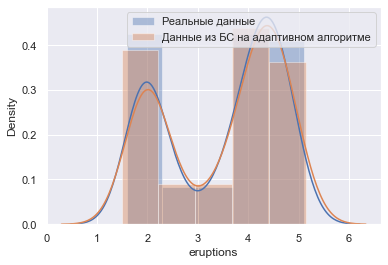

In [ ]:
sns.set(style="darkgrid")
sns.distplot(data[name], label='Реальные данные')
sns.distplot(sample1[name], label='Данные из БС на адаптивном алгоритме')
plt.legend()

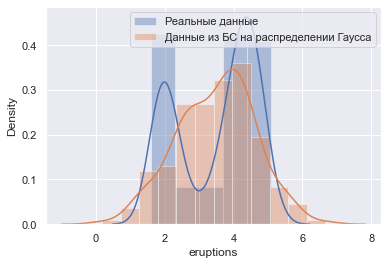

In [ ]:
sns.set(style="darkgrid")
sns.distplot(data[name], label='Реальные данные')
sns.distplot(sample2[name], label='Данные из БС на распределении Гаусса')
plt.legend()

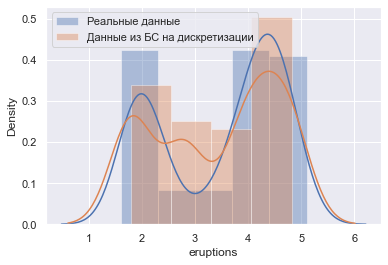

In [ ]:
sns.set(style="darkgrid")
sns.distplot(data[name], label='Реальные данные')
sns.distplot(sample_cont[name], label='Данные из БС на дискретизации')
plt.legend()

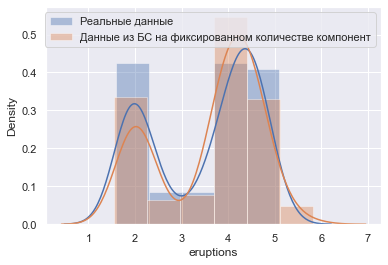

In [ ]:
sns.set(style="darkgrid")
sns.distplot(data[name], label='Реальные данные')
sns.distplot(sample3[name], label='Данные из БС на фиксированном количестве компонент')
plt.legend()

In [ ]:
# Расчет квантилей
percs = np.linspace(0, 100, 19)
qn_first = np.percentile(data[name], percs)
qn_second = np.percentile(sample1[name], percs)

conf_first = conf_intervals(data[name], qn_first)
conf_second = conf_intervals(sample1[name], qn_first)



qn_first1 = np.percentile(data[name], percs)
qn_second1 = np.percentile(sample2[name], percs)

conf_first1 = conf_intervals(data[name], qn_first1)
conf_second1 = conf_intervals(sample2[name], qn_first1)


qn_first2 = np.percentile(data[name], percs)
qn_second2 = np.percentile(sample_cont[name], percs)

conf_first2 = conf_intervals(data[name], qn_first2)
conf_second2 = conf_intervals(sample_cont[name], qn_first2)


qn_first3 = np.percentile(data[name], percs)
qn_second3 = np.percentile(sample3[name], percs)

conf_first3 = conf_intervals(data[name], qn_first3)
conf_second3 = conf_intervals(sample3[name], qn_first3)

In [ ]:
conf_first_list = []
conf_second_list = []
for element1, element2 in zip(conf_first, conf_second):
    conf_first_list.append(element1[0])
    conf_second_list.append(element2[0])



conf_first_list1 = []
conf_second_list1 = []
for element1, element2 in zip(conf_first1, conf_second1):
    conf_first_list1.append(element1[0])
    conf_second_list1.append(element2[0])

conf_first_list2 = []
conf_second_list2 = []
for element1, element2 in zip(conf_first2, conf_second2):
    conf_first_list2.append(element1[0])
    conf_second_list2.append(element2[0])


conf_first_list3 = []
conf_second_list3 = []
for element1, element2 in zip(conf_first3, conf_second3):
    conf_first_list3.append(element1[0])
    conf_second_list3.append(element2[0])

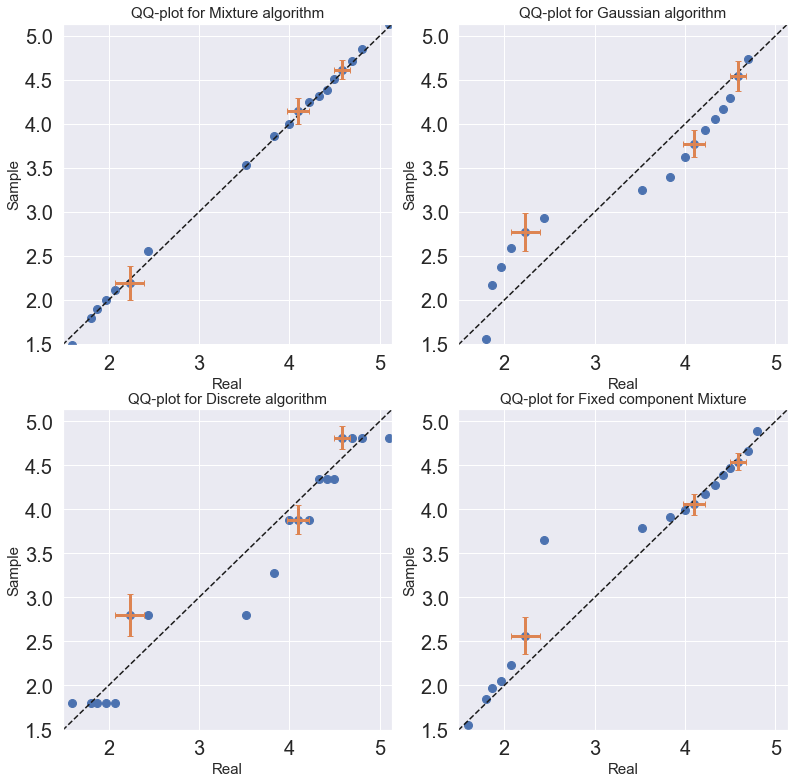

In [ ]:
# Построение квантильного биплота для двух случайных величин
sns.set(style="darkgrid")
fig, ax = plt.subplots(2, 2, figsize=(13,13))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

ax[0,0].plot(qn_first, qn_second, ls="", marker="o", markersize=8)
ax[0,0].plot(x, x, color="k", ls="--")
ax[0,0].set_xlabel('Real', fontsize=15)
ax[0,0].set_ylabel('Sample', fontsize=15)
ax[0,0].set_xlim([min_qn, max_qn])
ax[0,0].set_ylim([min_qn, max_qn])
ax[0,0].grid(True)
ax[0,0].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[0,0].errorbar(
    # [25%, 50%, 75%]
    [qn_first[5], qn_first[10], qn_first[15]],
    [qn_second[5], qn_second[10], qn_second[15]],
    xerr=conf_first_list,
    yerr=conf_second_list,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[0,0].set_title('QQ-plot for Mixture algorithm', fontsize=15)



ax[0,1].plot(qn_first1, qn_second1, ls="", marker="o", markersize=8)
ax[0,1].plot(x, x, color="k", ls="--")
ax[0,1].set_xlabel('Real', fontsize=15)
ax[0,1].set_ylabel('Sample', fontsize=15)
ax[0,1].set_xlim([min_qn, max_qn])
ax[0,1].set_ylim([min_qn, max_qn])
ax[0,1].grid(True)
ax[0,1].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[0,1].errorbar(
    # [25%, 50%, 75%]
    [qn_first1[5], qn_first1[10], qn_first1[15]],
    [qn_second1[5], qn_second1[10], qn_second1[15]],
    xerr=conf_first_list1,
    yerr=conf_second_list1,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[0,1].set_title('QQ-plot for Gaussian algorithm', fontsize=15)


ax[1,0].plot(qn_first2, qn_second2, ls="", marker="o", markersize=8)
ax[1,0].plot(x, x, color="k", ls="--")
ax[1,0].set_xlabel('Real', fontsize=15)
ax[1,0].set_ylabel('Sample', fontsize=15)
ax[1,0].set_xlim([min_qn, max_qn])
ax[1,0].set_ylim([min_qn, max_qn])
ax[1,0].grid(True)
ax[1,0].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[1,0].errorbar(
    # [25%, 50%, 75%]
    [qn_first2[5], qn_first2[10], qn_first2[15]],
    [qn_second2[5], qn_second2[10], qn_second2[15]],
    xerr=conf_first_list2,
    yerr=conf_second_list2,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[1,0].set_title('QQ-plot for Discrete algorithm', fontsize=15)



ax[1,1].plot(qn_first3, qn_second3, ls="", marker="o", markersize=8)
ax[1,1].plot(x, x, color="k", ls="--")
ax[1,1].set_xlabel('Real', fontsize=15)
ax[1,1].set_ylabel('Sample', fontsize=15)
ax[1,1].set_xlim([min_qn, max_qn])
ax[1,1].set_ylim([min_qn, max_qn])
ax[1,1].grid(True)
ax[1,1].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[1,1].errorbar(
    # [25%, 50%, 75%]
    [qn_first3[5], qn_first3[10], qn_first3[15]],
    [qn_second3[5], qn_second3[10], qn_second3[15]],
    xerr=conf_first_list3,
    yerr=conf_second_list3,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[1,1].set_title('QQ-plot for Fixed component Mixture', fontsize=15)
plt.savefig("erup_all.pdf", format="pdf", bbox_inches="tight", facecolor='white')

In [ ]:
geo = pd.read_csv('Shestakovo_validation3.csv')
geo

,DEPT,SP,GR,DT,DENS,LITHO,Well,X,Y
0,2509.8,-92.088417,84.218269,314.000732,2.321674,1,208-901,208,901
1,2509.9,-86.453247,88.521309,311.837647,2.328126,1,208-901,208,901
2,2510.0,-83.557259,88.436943,311.839600,2.330478,0,208-901,208,901
3,2510.1,-82.992027,84.618828,313.684082,2.329336,0,208-901,208,901
4,2510.2,-85.293060,79.385338,316.232727,2.325939,1,208-901,208,901
...,...,...,...,...,...,...,...,...,...
203094,2510.1,-75.068420,88.164665,312.681519,2.333706,1,244-924,244,924
203095,2510.2,-73.589851,89.532066,312.495911,2.333322,0,244-924,244,924
203096,2510.3,-72.232307,91.682045,311.912872,2.333808,0,244-924,244,924
203097,2510.4,-70.651291,93.851791,310.923492,2.335304,1,244-924,244,924


In [ ]:

geo = geo.loc[(geo['X'] == 208) & (geo['Y'] == 901)]
geo.reset_index(inplace=True, drop=True)

In [ ]:
cols = ['DEPT',	'SP',	'GR',	'DT',	'DENS']
geo = geo[cols]
geo = geo.astype(float)

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = Preprocessor([('discretizer', discretizer)])
discretized_data, est = p.apply(geo)
discretized_data, est = p.discretize(geo, discretizer)

2022-04-27 12:13:41,219 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [ ]:
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [ ]:
bn_gmm_geo = Nets.ContinuousBN(use_mixture=True)
bn_g_geo = Nets.ContinuousBN(use_mixture=False)
bn_g_geo.add_nodes(p.info)
bn_gmm_geo.add_nodes(p.info)
params1 = {'epsilon':0.0001, 'tabu':200}
bn_gmm_geo.add_edges(geo, scoring_function=('K2', BICGMM), params=params1)
bn_g_geo.add_edges(geo, scoring_function=('BIC', ))

  0%|          | 9/1000000 [01:18<2434:48:20,  8.77s/it] 


[322, 303, 290, 250, 88, 73, 32, 30, 10, -1]
---------------------


In [ ]:
bn_gmm_geo.fit_parameters(geo)
sample1 = bn_gmm_geo.sample(300)
#sample1 = sample1.loc[sample1['GR'] > 0]


bn_g_geo.fit_parameters(geo)
sample2 = bn_g_geo.sample(300)
#sample2 = sample2.loc[sample2['GR'] > 0]


In [ ]:
sample1.to_csv('geo_gmm_sample.csv', index=False)
sample2.to_csv('geo_g_sample.csv', index=False)

In [ ]:
discretizer = preprocessing.LabelEncoder()

p1 = Preprocessor([('discretizer', discretizer)])
discrete, est = p1.apply(discretized_data)

2022-04-26 22:01:55,064 | INFO     | Preprocessors.py-scan-0087 | No one column is continuous


In [ ]:
bn_d = Nets.DiscreteBN()
bn_d.add_nodes(p1.info)
bn_d.add_edges(discrete, scoring_function=('K2',BicScore), params=params2)

bn_d.fit_parameters(discrete)

  0%|          | 4/1000000 [00:00<13:22:39, 20.76it/s]

[163.30735785128365, 160.80141151645205, 119.72934757016924, 53.30506845451862, 0.0]
---------------------


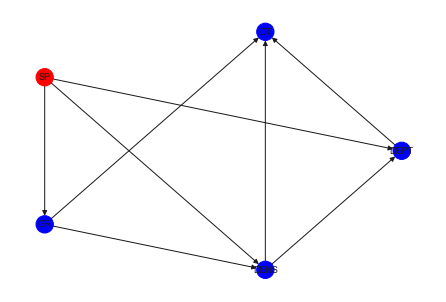

In [ ]:
name = 'SP'
import networkx as nx
sns.set(style="darkgrid")
color_map = []
graph = nx.DiGraph()
graph.add_edges_from(bn_gmm_geo.edges)
for n in graph.nodes:
    if n == name:
        color_map.append('red')
    else:
        color_map.append('blue')
nx.draw(graph, node_color=color_map, with_labels=True, pos=nx.circular_layout(graph), font_size=9, cmap='tab10')
plt.savefig('gmm_geo_graph.pdf', dpi=300, bbox_inches='tight', facecolor='white')

In [ ]:
sample = bn_d.sample(300)
sample = sample[geo.columns]

In [ ]:
#discretized_data, est = p.discretize(geo, discretizer)
sample_cont = pd.DataFrame(est.inverse_transform(sample.values), columns=geo.columns)

In [ ]:
sample_cont.to_csv('geo_discrete_sample.csv', index=False)

In [ ]:
name = 'SP'
data = copy(geo)

In [ ]:
sample1 = pd.read_csv('geo_gmm_sample.csv')
sample2 = pd.read_csv('geo_g_sample.csv')
sample_cont = pd.read_csv('geo_discrete_sample.csv')
sample3 = pd.read_csv('geo_d_gmm_sample.csv')

In [ ]:
# Расчет квантилей
percs = np.linspace(0, 100, 20)
qn_first = np.percentile(data[name], percs)
qn_second = np.percentile(sample1[name], percs)

conf_first = conf_intervals(data[name], qn_first)
conf_second = conf_intervals(sample1[name], qn_first)



qn_first1 = np.percentile(data[name], percs)
qn_second1 = np.percentile(sample2[name], percs)

conf_first1 = conf_intervals(data[name], qn_first1)
conf_second1 = conf_intervals(sample2[name], qn_first1)


qn_first2 = np.percentile(data[name], percs)
qn_second2 = np.percentile(sample_cont[name], percs)

conf_first2 = conf_intervals(data[name], qn_first2)
conf_second2 = conf_intervals(sample_cont[name], qn_first2)


qn_first3 = np.percentile(data[name], percs)
qn_second3 = np.percentile(sample3[name], percs)

conf_first3 = conf_intervals(data[name], qn_first3)
conf_second3 = conf_intervals(sample3[name], qn_first3)

In [ ]:
conf_first_list = []
conf_second_list = []
for element1, element2 in zip(conf_first, conf_second):
    conf_first_list.append(element1[0])
    conf_second_list.append(element2[0])



conf_first_list1 = []
conf_second_list1 = []
for element1, element2 in zip(conf_first1, conf_second1):
    conf_first_list1.append(element1[0])
    conf_second_list1.append(element2[0])

conf_first_list2 = []
conf_second_list2 = []
for element1, element2 in zip(conf_first2, conf_second2):
    conf_first_list2.append(element1[0])
    conf_second_list2.append(element2[0])


conf_first_list3 = []
conf_second_list3 = []
for element1, element2 in zip(conf_first3, conf_second3):
    conf_first_list3.append(element1[0])
    conf_second_list3.append(element2[0])

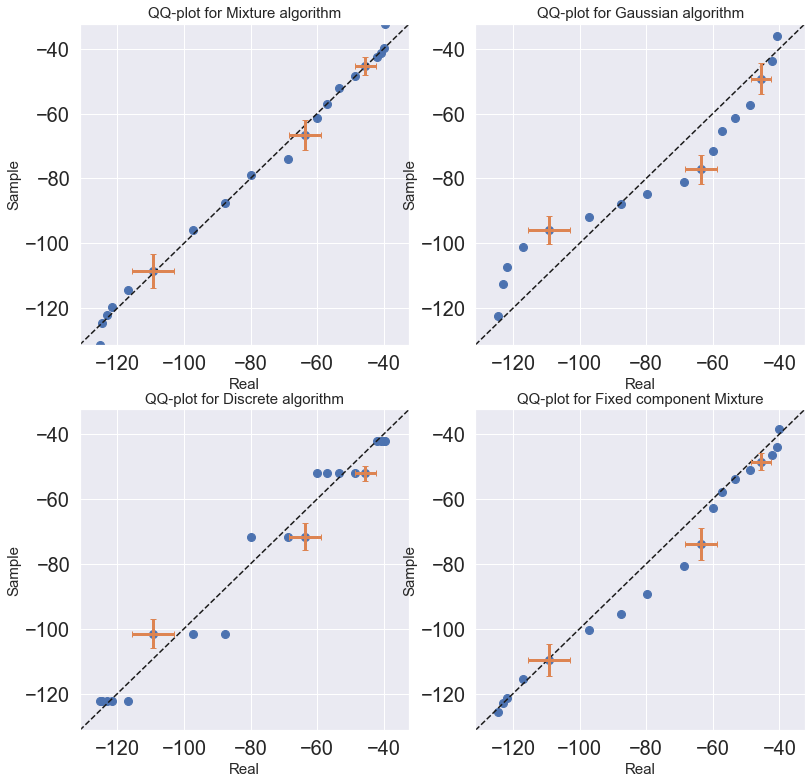

In [ ]:
# Построение квантильного биплота для двух случайных величин
sns.set(style="darkgrid")
fig, ax = plt.subplots(2, 2, figsize=(13,13))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

ax[0,0].plot(qn_first, qn_second, ls="", marker="o", markersize=8)
ax[0,0].plot(x, x, color="k", ls="--")
ax[0,0].set_xlabel('Real', fontsize=15)
ax[0,0].set_ylabel('Sample', fontsize=15)
ax[0,0].set_xlim([min_qn, max_qn])
ax[0,0].set_ylim([min_qn, max_qn])
ax[0,0].grid(True)
ax[0,0].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[0,0].errorbar(
    # [25%, 50%, 75%]
    [qn_first[5], qn_first[10], qn_first[15]],
    [qn_second[5], qn_second[10], qn_second[15]],
    xerr=conf_first_list,
    yerr=conf_second_list,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[0,0].set_title('QQ-plot for Mixture algorithm', fontsize=15)



ax[0,1].plot(qn_first1, qn_second1, ls="", marker="o", markersize=8)
ax[0,1].plot(x, x, color="k", ls="--")
ax[0,1].set_xlabel('Real', fontsize=15)
ax[0,1].set_ylabel('Sample', fontsize=15)
ax[0,1].set_xlim([min_qn, max_qn])
ax[0,1].set_ylim([min_qn, max_qn])
ax[0,1].grid(True)
ax[0,1].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[0,1].errorbar(
    # [25%, 50%, 75%]
    [qn_first1[5], qn_first1[10], qn_first1[15]],
    [qn_second1[5], qn_second1[10], qn_second1[15]],
    xerr=conf_first_list1,
    yerr=conf_second_list1,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[0,1].set_title('QQ-plot for Gaussian algorithm', fontsize=15)


ax[1,0].plot(qn_first2, qn_second2, ls="", marker="o", markersize=8)
ax[1,0].plot(x, x, color="k", ls="--")
ax[1,0].set_xlabel('Real', fontsize=15)
ax[1,0].set_ylabel('Sample', fontsize=15)
ax[1,0].set_xlim([min_qn, max_qn])
ax[1,0].set_ylim([min_qn, max_qn])
ax[1,0].grid(True)
ax[1,0].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[1,0].errorbar(
    # [25%, 50%, 75%]
    [qn_first2[5], qn_first2[10], qn_first2[15]],
    [qn_second2[5], qn_second2[10], qn_second2[15]],
    xerr=conf_first_list2,
    yerr=conf_second_list2,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[1,0].set_title('QQ-plot for Discrete algorithm', fontsize=15)



ax[1,1].plot(qn_first3, qn_second3, ls="", marker="o", markersize=8)
ax[1,1].plot(x, x, color="k", ls="--")
ax[1,1].set_xlabel('Real', fontsize=15)
ax[1,1].set_ylabel('Sample', fontsize=15)
ax[1,1].set_xlim([min_qn, max_qn])
ax[1,1].set_ylim([min_qn, max_qn])
ax[1,1].grid(True)
ax[1,1].tick_params(labelsize=20)

# Добавление доверительных интервалов на график
ax[1,1].errorbar(
    # [25%, 50%, 75%]
    [qn_first3[5], qn_first3[10], qn_first3[15]],
    [qn_second3[5], qn_second3[10], qn_second3[15]],
    xerr=conf_first_list3,
    yerr=conf_second_list3,
    ls='none',
    capsize=3,
    elinewidth=3
)

ax[1,1].set_title('QQ-plot for Fixed component Mixture', fontsize=15)
plt.savefig("geo_all.pdf", format="pdf", bbox_inches="tight", facecolor='white')

In [ ]:
import random
K = 3
means = []
covs = []
w = []
N = 500
for _ in range(K):
    means.append([random.randint(0, 10)])
    covs.append(np.array([[random.randint(0, 5)]]))
    w.append(1/K)
gmm = GMM(n_components=K, priors=w, means=means, covariances=covs)
W = gmm.sample(N)


In [ ]:
Nx = np.random.uniform(-1, 1, 500)
Nx = Nx.reshape(500,1)
X = W*W + Nx

In [ ]:
Ny = np.random.uniform(-1, 1, 500)
Ny = Ny.reshape(500,1)
Y = 4*np.sqrt(np.abs(W))  + Ny

In [ ]:
Nz = np.random.uniform(-1, 1, 500)
Nz = Nz.reshape(500,1)
Z = 2*np.sin(X) + 1*np.sin(Y) +Nz

In [ ]:
synth_data = pd.DataFrame()
synth_data['W'] = W.reshape(500,)
synth_data['X'] = X.reshape(500,)
synth_data['Y'] = Y.reshape(500,)
synth_data['Z'] = Z.reshape(500,)


In [ ]:
synth_data.to_csv('synth_data.csv', index=False)

In [ ]:
true_net = [('W', 'X'), ('W', 'Y'), ('X', 'Z'), ('Y', 'Z')]

In [ ]:

discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

p = Preprocessor([('discretizer', discretizer)])
discretized_data, est = p.apply(synth_data)
discretized_data, est = p.discretize(synth_data, discretizer)


2022-04-08 15:23:39,699 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [ ]:
encoder = preprocessing.LabelEncoder()

p1 = Preprocessor([('encoder', encoder)])
discrete, est1 = p1.apply(discretized_data)

2022-04-08 15:23:43,152 | INFO     | Preprocessors.py-scan-0087 | No one column is continuous


In [ ]:
bn_gmm = Nets.ContinuousBN(use_mixture=True)
bn_gmm.add_nodes(p.info)
bn_gmm.add_edges(synth_data, scoring_function=('K2', BICGMM))

  0%|          | 4/1000000 [01:05<4527:38:18, 16.30s/it] 


In [ ]:
bn_gmm.fit_parameters(synth_data)
test = synth_data.drop(columns=['Y'])
pred1 = bn_gmm.predict(test)

100%|██████████| 500/500 [00:01<00:00, 272.09it/s]


In [ ]:
precision_recall(bn_gmm.edges, true_net)

{'AP': 1.0, 'AR': 1.0, 'AHP': 0.75, 'AHR': 0.75, 'SHD': 1}

In [ ]:
bn_gmm = Nets.DiscreteBN()
bn_gmm.add_nodes(p1.info)
bn_gmm.add_edges(discrete, scoring_function=('K2', K2Score))


  0%|          | 4/1000000 [00:00<18:24:13, 15.09it/s]


In [ ]:
bn_gmm.get_info()

,name,node_type,data_type,parents,parents_types
0,W,Discrete,disc_num,[X],[disc_num]
1,X,Discrete,disc_num,[],[]
2,Y,Discrete,disc_num,"[W, X]","[disc_num, disc_num]"
3,Z,Discrete,disc_num,[Y],[disc_num]


In [ ]:
bn_gmm.fit_parameters(discrete)
test = discrete.drop(columns=['Y'])
pred2 = bn_gmm.predict(test)

100%|██████████| 500/500 [00:00<00:00, 743.80it/s]


In [ ]:
precision_recall(bn_gmm.edges, true_net)

{'AP': 0.75, 'AR': 0.75, 'AHP': 0.5, 'AHR': 0.5, 'SHD': 3}

In [ ]:
test['Y'] = pred2['Y']

In [ ]:
test = test[['W',	'X',	'Y',	'Z']]

In [ ]:
test_cont = pd.DataFrame(est.inverse_transform(test.values), columns=['W',	'X',	'Y',	'Z'])

In [ ]:
bn_gmm = Nets.ContinuousBN(use_mixture=False)
bn_gmm.add_nodes(p.info)
bn_gmm.add_edges(synth_data, scoring_function=('BIC', ))

In [ ]:
precision_recall(bn_gmm.edges, true_net)

{'AP': 0.8, 'AR': 1.0, 'AHP': 0.2, 'AHR': 0.25, 'SHD': 4}

In [ ]:
bn_gmm.fit_parameters(synth_data)
test = synth_data.drop(columns=['Y'])
pred3 = bn_gmm.predict(test)

100%|██████████| 500/500 [00:00<00:00, 704.51it/s]


In [ ]:
pred3

{'Y': [5.1532669356632095,
  3.0695851987195963,
  5.024737899753035,
  4.109744641318035,
  5.926066355341935,
  2.7552393909993826,
  4.304423603278538,
  5.71822040608632,
  3.8937490467676854,
  5.43574316150372,
  6.604443274365675,
  6.850455971630918,
  6.1311980794344425,
  3.4494120336391485,
  3.952868004127152,
  5.321997320815471,
  5.676298257071788,
  7.893367118203316,
  4.902893629665174,
  4.66060222187882,
  3.7923832426500743,
  4.037602120267161,
  5.535980953847215,
  3.726228653988521,
  5.957927562501398,
  6.48337554810534,
  3.796432598697673,
  6.820679932552286,
  4.88308205049735,
  5.224234824471782,
  6.752571738377465,
  5.766292570321339,
  4.282252528448198,
  5.181660613302852,
  6.788343504228293,
  3.9428231108510277,
  6.998610385803586,
  5.326919775077722,
  4.231858423833661,
  3.024040771615135,
  5.163859919420812,
  1.9021902184938821,
  4.192843713708198,
  3.064281745541251,
  2.1120379641937337,
  5.56101900874402,
  3.5051206688202,
  5.21

In [ ]:
w = sorted(synth_data['W'].values)
pred1y = [x for _,x in sorted(zip(synth_data['W'].values,pred1['Y']))]
pred2y = [x for _,x in sorted(zip(synth_data['W'].values,test_cont['Y'].values))]
pred3y = [x for _,x in sorted(zip(synth_data['W'].values,pred3['Y']))]

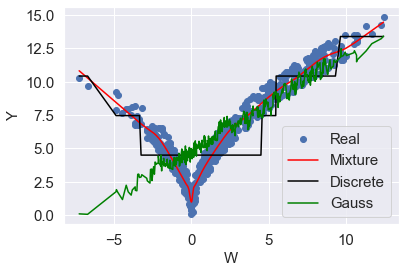

In [ ]:
plt.scatter(synth_data['W'], synth_data['Y'], label='Real')
plt.plot(w, pred1y, color='red', label='Mixture')
plt.plot(w, pred2y, label='Discrete', color='black')
plt.plot(w, pred3y, label='Gauss', color='green')
plt.tick_params(labelsize=15)
plt.xlabel('W', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.legend(fontsize=15)
plt.savefig("simple_ex.pdf", format="pdf", bbox_inches="tight", facecolor='w')

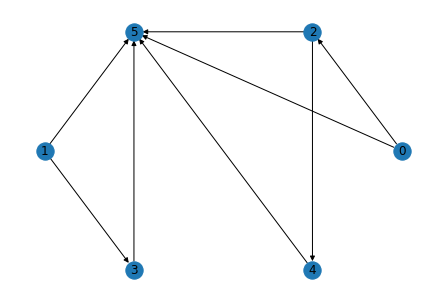

In [ ]:
import networkx as nx
import random

G=nx.gnp_random_graph(6,0.5,directed=True)
DAG = nx.DiGraph([(u,v) for (u,v) in G.edges() if u<v])
nx.draw_circular(DAG, with_labels=True)

In [ ]:
import timeit

number_nodes = [5, 6, 7, 8, 9, 10]
K = 3
N = 500
functions = ['cos', 'sin', 'sqrt', 'x^2', 'x']
result_df = pd.DataFrame(columns=['Number nodes', 'Niter', 'Max', 'Min', 'Mean', 'Delta score', 'Delta true', 'Min shd'])
for n in number_nodes:
    print(n)
    print('-----')
    for j in range(7):
        try:
            print(j)
            min_v = random.randint(1, 50)
            max_v = random.randint(60, 200)
            is_all = True
            DAG = []
            while is_all == True:
                G=nx.gnp_random_graph(n,0.5,directed=True)
                DAG = nx.DiGraph([(u,v) for (u,v) in G.edges() if u<v])
                if len(DAG.nodes) == n:
                    is_all =False
            sample = np.empty(n, dtype=object)
            for v in list(nx.topological_sort(DAG)):
                if len(DAG.pred[v]) == 0:
                    means = []
                    covs = []
                    w = []
                    for _ in range(K):
                        means.append([random.randint(min_v, max_v)])
                        covs.append(np.array([[1]]))
                        w.append(1/K)
                    gmm = GMM(n_components=K, priors=w, means=means, covariances=covs)
                    W = gmm.sample(N)
                    sample[v] = W
                else:
                    parents = list(dict(DAG.pred[v]).keys())
                    #V = np.random.normal(0, 1, N)
                    #V = V.reshape(N,1)
                    V = np.zeros((N,1))
                    for p in parents:
                        f_i = functions[random.randint(0,4)]
                        if f_i == 'cos':
                            V = V + np.cos(sample[p])
                        if f_i == 'sqrt':
                            V = V + np.sqrt(np.abs(sample[p]))
                        if f_i == 'sin':
                            V = V + np.sin(sample[p])
                        if f_i == 'x^2':
                            V = V + (sample[p])*(sample[p])
                        if f_i == 'x':
                            V = V + 2*(sample[p])
                    sample[v] = V
            sample_df = pd.DataFrame()
            for i in range(n):
                sample_df[str(i)] = sample[i].reshape(N,)
            true_net = []
            for e in DAG.edges:
                true_net.append([str(e[0]), str(e[1])])
            est = HillClimbSearch(sample_df)
            best_model, delta_val, models = est.estimate(scoring_method=BICGMM(sample_df))
            scores = []
            for m in models:
                scores.append(BICGMM(sample_df).score(BayesianNetwork(m)))
            true_score = BICGMM(sample_df).score(BayesianNetwork(true_net))
            shd = []
            for m in models:
                shd.append(precision_recall(m, true_net)['SHD']) 
            index_min = np.argmin(shd)
            delta_score = delta_val[index_min]
            delta_true = true_score - scores[index_min]
            min_val = np.amin(sample_df.values)
            max_val = np.amax(sample_df.values)
            mean_val = np.mean(sample_df.values)
            row = {'Number nodes':n, 'Niter':j, 'Max':max_val, 'Min':min_val, 'Mean':mean_val, 'Delta score':delta_score, 'Delta true':delta_true, 'Min shd':shd[index_min]}
            result_df = result_df.append(row, ignore_index=True)
        except:
            continue





5
-----
0


  0%|          | 9/1000000 [01:25<2649:17:56,  9.54s/it] 


1


  0%|          | 6/1000000 [01:27<4059:52:35, 14.62s/it] 


2


  0%|          | 8/1000000 [01:17<2685:35:15,  9.67s/it] 


3


  0%|          | 9/1000000 [01:20<2490:59:20,  8.97s/it] 


4


  0%|          | 9/1000000 [01:29<2750:03:00,  9.90s/it] 


5


  0%|          | 7/1000000 [01:16<3038:54:54, 10.94s/it] 


6


  0%|          | 9/1000000 [01:32<2855:40:23, 10.28s/it] 


6
-----
0


  0%|          | 10/1000000 [02:35<4311:43:50, 15.52s/it]


1


  0%|          | 10/1000000 [02:12<3690:55:22, 13.29s/it]


2


  0%|          | 13/1000000 [03:03<3924:36:41, 14.13s/it]


3


  0%|          | 11/1000000 [02:29<3779:14:23, 13.61s/it]


4


  0%|          | 10/1000000 [02:06<3527:26:28, 12.70s/it]


5


  0%|          | 12/1000000 [02:47<3888:49:01, 14.00s/it]


6


  0%|          | 8/1000000 [02:02<4264:02:50, 15.35s/it] 


7
-----
0


  0%|          | 15/1000000 [03:34<3972:46:25, 14.30s/it]


1


  0%|          | 13/1000000 [03:21<4303:42:19, 15.49s/it]


2


  0%|          | 14/1000000 [03:49<4558:10:24, 16.41s/it] 


3


  0%|          | 14/1000000 [03:35<4272:24:02, 15.38s/it]


4


  0%|          | 15/1000000 [03:28<3857:56:54, 13.89s/it]


5


  0%|          | 11/1000000 [02:54<4416:44:34, 15.90s/it]


6


  0%|          | 14/1000000 [03:14<3854:57:59, 13.88s/it]


8
-----
0


  0%|          | 23/1000000 [05:30<3997:10:17, 14.39s/it] 


1


  0%|          | 12/1000000 [04:55<6843:40:40, 24.64s/it] 


2


  0%|          | 25/1000000 [06:41<4464:57:45, 16.07s/it] 


3


  0%|          | 21/1000000 [05:42<4524:31:45, 16.29s/it] 


4


  0%|          | 18/1000000 [04:38<4303:33:00, 15.49s/it]


5


  0%|          | 21/1000000 [06:36<5248:42:23, 18.90s/it] 


6


  0%|          | 18/1000000 [05:12<4826:29:13, 17.38s/it]


9
-----
0


  0%|          | 26/1000000 [08:46<5619:36:42, 20.23s/it] 


1


  0%|          | 23/1000000 [07:28<5415:58:54, 19.50s/it] 


2


  0%|          | 15/1000000 [06:11<6880:22:08, 24.77s/it] 


3


  0%|          | 21/1000000 [07:18<5797:04:35, 20.87s/it] 


4


  0%|          | 19/1000000 [07:03<6184:35:01, 22.26s/it] 


5


  0%|          | 16/1000000 [05:58<6220:34:14, 22.39s/it] 


6


  0%|          | 20/1000000 [06:59<5832:29:30, 21.00s/it] 


10
-----
0


  0%|          | 34/1000000 [11:56<5851:58:01, 21.07s/it] 


1


  0%|          | 20/1000000 [07:47<6497:30:26, 23.39s/it] 


2


  0%|          | 26/1000000 [10:50<6948:06:27, 25.01s/it] 


3


  0%|          | 18/1000000 [08:41<8055:18:39, 29.00s/it] 


4


  0%|          | 27/1000000 [10:24<6428:03:00, 23.14s/it] 


5


  0%|          | 23/1000000 [10:48<7831:05:11, 28.19s/it] 


6


  0%|          | 27/1000000 [10:30<6485:56:37, 23.35s/it] 


In [ ]:
result_df

,Number nodes,Niter,Max,Min,Mean,Delta score,Delta true,Min shd
0,5.0,0.0,278.162476,3.243716,71.12554,399.0,-194.0,2.0
1,5.0,1.0,148.947459,-0.999999,47.28125,3081.0,642.0,4.0
2,5.0,2.0,37795.70139,49.843413,5979.798302,492.0,-1473.0,3.0
3,5.0,3.0,229.283989,6.674059,89.068121,462.0,-1835.0,3.0
4,5.0,4.0,8419.44375,26.570487,821.03519,1.0,-1277.0,3.0
5,5.0,5.0,14145.115733,-0.999989,1590.906041,2594.0,-5405.0,4.0
6,5.0,6.0,14523.568774,-1.994148,1360.964787,479.0,-141.0,5.0
7,6.0,0.0,584249.154277,-1.881561,33133.129406,3864.0,3272.0,9.0
8,6.0,1.0,1138264278.470686,-1.975281,100358634.375497,3777.0,-11214.0,6.0
9,6.0,2.0,181.088052,-1.990148,20.438124,3049.0,5910.0,6.0


<AxesSubplot:xlabel='Number nodes', ylabel='Delta score'>

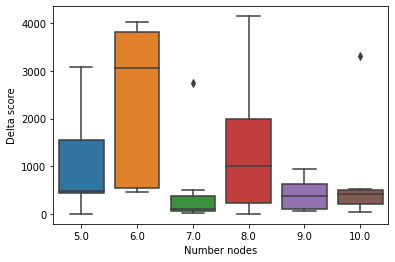

In [ ]:
sns.boxplot(x='Number nodes', y='Delta score', data=result_df)

In [ ]:
result_df.to_csv('Min_shd_gmm.csv', index=False)

In [ ]:

import math
number_nodes = [5, 6, 7, 8, 9, 10]
K = 3
N = 500
functions = ['cos', 'sin', 'sqrt', 'x^2', 'x']
result_df_delta = pd.DataFrame(columns=['Number nodes', 'Niter', 'Max', 'Min', 'Mean', 'Delta score', 'shd', 'Min delta true'])
for n in number_nodes:
    print(n)
    print('-----')
    for j in range(7):
        try:
            print(j)
            min_v = random.randint(1, 50)
            max_v = random.randint(60, 200)
            is_all = True
            DAG = []
            while is_all == True:
                G=nx.gnp_random_graph(n,0.5,directed=True)
                DAG = nx.DiGraph([(u,v) for (u,v) in G.edges() if u<v])
                if len(DAG.nodes) == n:
                    is_all =False
            sample = np.empty(n, dtype=object)
            for v in list(nx.topological_sort(DAG)):
                if len(DAG.pred[v]) == 0:
                    means = []
                    covs = []
                    w = []
                    for _ in range(K):
                        means.append([random.randint(min_v, max_v)])
                        covs.append(np.array([[1]]))
                        w.append(1/K)
                    gmm = GMM(n_components=K, priors=w, means=means, covariances=covs)
                    W = gmm.sample(N)
                    sample[v] = W
                else:
                    parents = list(dict(DAG.pred[v]).keys())
                    #V = np.random.normal(0, 1, N)
                    #V = V.reshape(N,1)
                    V = np.zeros((N,1))
                    for p in parents:
                        f_i = functions[random.randint(0,4)]
                        if f_i == 'cos':
                            V = V + np.cos(sample[p])
                        if f_i == 'sqrt':
                            V = V + np.sqrt(np.abs(sample[p]))
                        if f_i == 'sin':
                            V = V + np.sin(sample[p])
                        if f_i == 'x^2':
                            V = V + (sample[p])*(sample[p])
                        if f_i == 'x':
                            V = V + 2*(sample[p])
                    sample[v] = V
            sample_df = pd.DataFrame()
            for i in range(n):
                sample_df[str(i)] = sample[i].reshape(N,)
            true_net = []
            for e in DAG.edges:
                true_net.append([str(e[0]), str(e[1])])
            est = HillClimbSearch(sample_df)
            best_model, delta_val, models = est.estimate(scoring_method=BICGMM(sample_df))
            scores = []
            for m in models:
                scores.append(BICGMM(sample_df).score(BayesianNetwork(m)))
            true_score = BICGMM(sample_df).score(BayesianNetwork(true_net))
            shd = []
            for m in models:
                shd.append(precision_recall(m, true_net)['SHD']) 
            delts_true = [math.fabs(p-true_score) for p in scores]
            index_min = np.argmin(delts_true)
            delta_score = delta_val[index_min]
            shd_val = shd[index_min]
            min_val = np.amin(sample_df.values)
            max_val = np.amax(sample_df.values)
            mean_val = np.mean(sample_df.values)
            row = {'Number nodes':n, 'Niter':j, 'Max':max_val, 'Min':min_val, 'Mean':mean_val, 'Delta score':delta_score, 'shd':shd_val, 'Min delta true':delts_true[index_min]}
            result_df_delta = result_df_delta.append(row, ignore_index=True)
        except:
            continue





5
-----
0


  0%|          | 6/1000000 [01:18<3657:17:10, 13.17s/it] 


1


  0%|          | 8/1000000 [01:25<2971:41:19, 10.70s/it] 


2


  0%|          | 5/1000000 [01:11<3975:16:21, 14.31s/it] 


3


  0%|          | 9/1000000 [01:26<2656:02:36,  9.56s/it] 


4


  0%|          | 7/1000000 [01:29<3537:14:37, 12.73s/it] 


5


  0%|          | 6/1000000 [01:24<3900:08:04, 14.04s/it] 


6


  0%|          | 7/1000000 [01:16<3055:08:00, 11.00s/it] 


6
-----
0


  0%|          | 8/1000000 [02:17<4767:50:09, 17.16s/it] 


1


  0%|          | 12/1000000 [02:34<3569:09:01, 12.85s/it]


2


  0%|          | 11/1000000 [02:45<4186:13:03, 15.07s/it]


3


  0%|          | 11/1000000 [02:45<4186:09:27, 15.07s/it]


4


  0%|          | 8/1000000 [01:57<4073:20:43, 14.66s/it] 


5


  0%|          | 8/1000000 [01:57<4075:28:56, 14.67s/it] 


6


  0%|          | 10/1000000 [02:15<3754:43:55, 13.52s/it]


7
-----
0


  0%|          | 9/1000000 [02:38<4881:50:08, 17.57s/it] 


1


  0%|          | 13/1000000 [03:16<4207:05:04, 15.15s/it]


2


  0%|          | 14/1000000 [03:28<4134:38:41, 14.88s/it]


3


  0%|          | 19/1000000 [04:04<3568:19:32, 12.85s/it]


4


  0%|          | 14/1000000 [03:20<3983:30:06, 14.34s/it]


5


  0%|          | 11/1000000 [02:52<4355:25:24, 15.68s/it]


6


  0%|          | 11/1000000 [03:03<4627:34:40, 16.66s/it]


8
-----
0


  0%|          | 21/1000000 [05:15<4166:53:21, 15.00s/it] 


1


  0%|          | 15/1000000 [05:08<5715:40:37, 20.58s/it] 


2


  0%|          | 18/1000000 [05:15<4865:45:25, 17.52s/it] 


3


  0%|          | 16/1000000 [05:34<5804:41:38, 20.90s/it] 


4


  0%|          | 15/1000000 [04:38<5151:05:51, 18.54s/it] 


5


  0%|          | 17/1000000 [05:40<5570:11:12, 20.05s/it] 


6


  0%|          | 12/1000000 [04:50<6713:45:07, 24.17s/it] 


9
-----
0


  0%|          | 19/1000000 [07:19<6429:49:42, 23.15s/it] 


1


  0%|          | 18/1000000 [06:02<5588:18:18, 20.12s/it] 


2


  0%|          | 20/1000000 [06:24<5341:41:36, 19.23s/it] 


3


  0%|          | 24/1000000 [06:59<4857:35:19, 17.49s/it] 


4


  0%|          | 24/1000000 [06:40<4635:09:45, 16.69s/it] 


5


  0%|          | 23/1000000 [07:56<5752:37:10, 20.71s/it] 


6


  0%|          | 23/1000000 [07:08<5176:46:19, 18.64s/it] 


10
-----
0


  0%|          | 19/1000000 [08:19<7307:55:00, 26.31s/it] 


1


  0%|          | 25/1000000 [08:41<5794:30:40, 20.86s/it] 


2


  0%|          | 31/1000000 [11:22<6115:42:34, 22.02s/it] 


3


  0%|          | 36/1000000 [13:04<6053:01:17, 21.79s/it] 


4


  0%|          | 22/1000000 [08:45<6629:22:47, 23.87s/it] 


5


  0%|          | 25/1000000 [08:49<5884:43:34, 21.19s/it] 


6


  0%|          | 23/1000000 [10:02<7274:19:23, 26.19s/it] 


In [ ]:
result_df_delta.to_csv('Min_delta_score_gmm.csv', index=False)

<AxesSubplot:xlabel='Number nodes', ylabel='Delta score'>

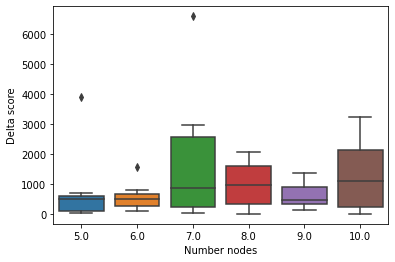

In [ ]:
sns.boxplot(x='Number nodes', y='Delta score', data=result_df_delta)

In [ ]:
scores = []
for m in models:
    scores.append(BICGMM(sample_df).score(BayesianNetwork(m)))

In [ ]:
true_score = BICGMM(sample_df).score(BayesianNetwork(true_net))

In [ ]:
shd = []
for m in models:
    shd.append(precision_recall(m, true_net)['SHD']) 

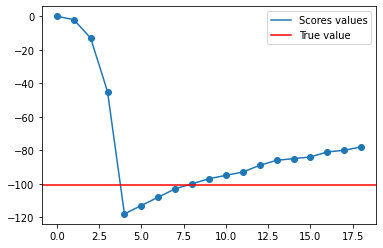

In [ ]:
plt.plot([i for i in range(len(scores))], scores, label='Scores values')
plt.scatter([i for i in range(len(scores))], scores)
plt.axhline(y=true_score, label='True value',c='red')
plt.legend()

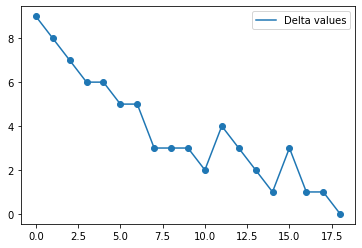

In [ ]:
plt.plot([i for i in range(len(delta_val))], delta_val, label='Delta values')
plt.scatter([i for i in range(len(delta_val))], delta_val)
plt.legend()

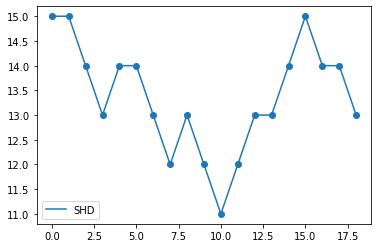

In [ ]:
plt.plot([i for i in range(len(shd))], shd, label='SHD')
plt.scatter([i for i in range(len(shd))], shd)
plt.legend()

In [ ]:
scores

[-6, -6, -6, -3, -3]

In [ ]:
t1

[0.11390269999999703]

In [ ]:
t2

[36.6550125]

In [ ]:
t3

[0.427966099999999]

In [ ]:
K2_score

[{'AP': 1.0, 'AR': 0.33, 'AHP': 0.5, 'AHR': 0.17, 'SHD': 5}]

In [ ]:
GMM_score

[{'AP': 0.8, 'AR': 0.67, 'AHP': 0.4, 'AHR': 0.33, 'SHD': 5}]

In [ ]:
Gauss_score

[{'AP': 0.57, 'AR': 0.67, 'AHP': 0.29, 'AHR': 0.33, 'SHD': 7}]

In [ ]:
import timeit
K2_score = []
GMM_score = []
Gauss_score = []
functions = ['cos', 'sin', 'sqrt', 'x^2']
t1 = []
t2 = []
t3 = []
K = 3
N = 200
for gi in range(5):
    print(gi)
    number_nodes = 5
    is_all = True
    DAG = []
    while is_all == True:
        G=nx.gnp_random_graph(number_nodes,0.5,directed=True)
        DAG = nx.DiGraph([(u,v) for (u,v) in G.edges() if u<v])
        if len(DAG.nodes) == number_nodes:
            is_all =False
    # k2= []
    # bicgmm = []
    # gaussbic = []
    # mi = []

    #for parami in range(5):
    sample = np.empty(number_nodes, dtype=object)
    for v in list(nx.topological_sort(DAG)):
        if len(DAG.pred[v]) == 0:
            means = []
            covs = []
            w = []
            for _ in range(K):
                means.append([random.randint(5, 30)])
                covs.append(np.array([[1]]))
                w.append(1/K)
            gmm = GMM(n_components=K, priors=w, means=means, covariances=covs)
            W = gmm.sample(N)
            sample[v] = W
        else:
            parents = list(dict(DAG.pred[v]).keys())
            V = np.random.normal(0, 1, N)
            V = V.reshape(N,1)
            #V = np.zeros((N,1))
            for p in parents:
                f_i = functions[random.randint(0,3)]
                if f_i == 'cos':
                    V = V + np.cos(sample[p])
                if f_i == 'sqrt':
                    V = V + np.sqrt(np.abs(sample[p]))
                if f_i == 'sin':
                    V = V + np.sin(sample[p])
                if f_i == 'x^2':
                    V = V + (sample[p])*(sample[p])
                if f_i == 'x':
                    V = V + 2*(sample[p])
            sample[v] = V
    sample_df = pd.DataFrame()
    for i in range(number_nodes):
        sample_df[str(i)] = sample[i].reshape(N,)

    true_net = []
    for e in DAG.edges:
        true_net.append([str(e[0]), str(e[1])])
   

    
    try:
        discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
        p = Preprocessor([('discretizer', discretizer)])
        discretized_data, est = p.apply(sample_df)
        start = timeit.default_timer()
        bn_gmm = Nets.ContinuousBN(use_mixture=True)
        bn_gmm.add_nodes(p.info)
        params = {'epsilon': 0.0001, 'tabu':2000}
        bn_gmm.add_edges(discretized_data, scoring_function=('K2', BicScore), params=params)
        stop = timeit.default_timer()
        t1.append(stop - start)
        K2_score.append(precision_recall(bn_gmm.edges, true_net))

        start = timeit.default_timer()
        bn_gmm = Nets.ContinuousBN(use_mixture=True)
        bn_gmm.add_nodes(p.info)
        params = {'epsilon': 0.0001, 'tabu':2000}
        bn_gmm.add_edges(sample_df, scoring_function=('K2', BICGMM),params=params )
        stop = timeit.default_timer()
        t2.append(stop - start)
        GMM_score.append(precision_recall(bn_gmm.edges, true_net))

        start = timeit.default_timer()
        bn_gmm = Nets.ContinuousBN(use_mixture=True)
        bn_gmm.add_nodes(p.info)
        bn_gmm.add_edges(sample_df, scoring_function=('BIC', ))
        stop = timeit.default_timer()
        t3.append(stop - start)
        Gauss_score.append(precision_recall(bn_gmm.edges, true_net))
    except:
        continue
  



0
2022-04-25 23:16:37,903 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


  0%|          | 5/1000000 [00:00<33:35:42,  8.27it/s] 


[260.82159152847845, 247.84391642886823, 69.75208927467804, 45.289284917746045, 39.50071767113775, 0.0]
---------------------


  0%|          | 14/1000000 [04:58<5928:14:00, 21.34s/it] 


[784, 730, 127, 121, 86, 54, 34, 54, 33, 31, 30, 36, 45, 27, 15]
---------------------
1
2022-04-25 23:21:40,675 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


  0%|          | 8/1000000 [00:00<29:12:42,  9.51it/s] 


[279.50104355443574, 279.50104355443574, 279.50104355443574, 260.82159152847845, 220.83670694261565, 27.18068668632975, 12.920396177079454, 1.0748659892015553, -1.1368683772161603e-13]
---------------------


  0%|          | 10/1000000 [04:03<6761:07:08, 24.34s/it] 


[2040, 1324, 966, 889, 447, 122, 77, 61, 50, 49, 19]
---------------------
2
2022-04-25 23:25:47,643 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


  0%|          | 5/1000000 [00:00<30:32:36,  9.09it/s]


[270.14849562343323, 108.38784534811549, 107.93929399555321, 50.46703026274395, 20.356196437884705, 0.0]
---------------------


  0%|          | 15/1000000 [04:31<5029:52:49, 18.11s/it] 


[918, 220, 204, 137, 73, 50, 49, 43, 39, 41, 32, 31, 27, 30, 24, 12]
---------------------
3
2022-04-25 23:30:22,791 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


  0%|          | 5/1000000 [00:00<29:16:11,  9.49it/s]


[98.02144216721501, 86.95223345228018, 72.17916072774847, 50.436148431053994, 34.106131402763026, 0.0]
---------------------


  0%|          | 19/1000000 [05:23<4734:43:39, 17.05s/it] 


[308, 427, 271, 180, 144, 134, 56, 53, 63, 58, 46, 31, 31, 30, 30, 29, 24, 22, 25, 14]
---------------------
4
2022-04-25 23:35:50,115 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


  0%|          | 7/1000000 [00:00<24:00:18, 11.57it/s]


[279.50104355443574, 279.50104355443574, 270.14849562343323, 128.9374338876589, 79.69363667939825, 64.61795756092448, 48.63266071039709, 2.842170943040401e-14]
---------------------


  0%|          | 18/1000000 [05:15<4864:08:34, 17.51s/it] 


[1131, 898, 871, 250, 237, 171, 109, 36, 34, 33, 47, 34, 30, 28, 38, 25, 23, 29, 17]
---------------------


In [ ]:
metrics_df = pd.DataFrame(columns=['Method', 'Number nodes', 'SHD', 'AP', 'AR', 'AHP', 'AHR'])

In [ ]:
for g in GMM_score:
    metrics_df = metrics_df.append({'Method':'Mixture', 'Number nodes':10, 'SHD':g['SHD'], 'AP':g['AP'], 'AR':g['AR'], 'AHP':g['AHP'], 'AHR':g['AHR']}, ignore_index=True)

In [ ]:
for g in Gauss_score:
    metrics_df = metrics_df.append({'Method':'Gauss', 'Number nodes':10, 'SHD':g['SHD'], 'AP':g['AP'], 'AR':g['AR'], 'AHP':g['AHP'], 'AHR':g['AHR']}, ignore_index=True)

In [ ]:
for g in K2_score:

    metrics_df = metrics_df.append({'Method':'Discrete', 'Number nodes':10, 'SHD':g['SHD'], 'AP':g['AP'], 'AR':g['AR'], 'AHP':g['AHP'], 'AHR':g['AHR']}, ignore_index=True)

In [ ]:
for i in range(metrics_df.shape[0]):
    if metrics_df.loc[i, 'Method'] == 'K2':
        metrics_df.loc[i, 'Method'] = 'Discrete'


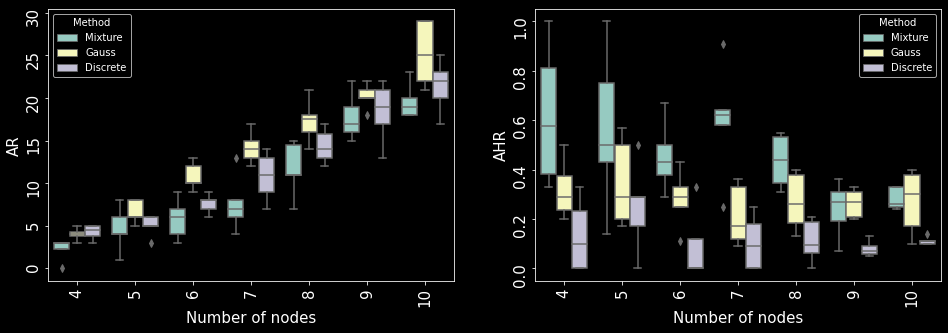

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))



sns.boxplot(ax=ax[0], x='Number nodes', y = 'SHD', hue='Method', data =metrics_df)
ax[0].set_ylabel('AR', fontsize=15)
ax[0].set_xlabel('Number of nodes', fontsize=15)
ax[0].tick_params(labelsize=15, rotation=90)
#ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
sns.boxplot(ax=ax[1], x='Number nodes', y = 'AHR', hue='Method', data =metrics_df)
ax[1].set_ylabel('AHR', fontsize=15)
ax[1].set_xlabel('Number of nodes', fontsize=15)
ax[1].tick_params(labelsize=15, rotation=90)
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
#plt.savefig("Random_all.pdf", format="pdf", bbox_inches="tight", facecolor='w')

In [ ]:
metrics_df.to_csv('gmm_metrics_v2.csv', index=False)

In [ ]:
metrics_df = pd.read_csv('gmm_metrics_v2.csv')

In [ ]:
mean_shod = pd.DataFrame(metrics_df.groupby(['Number nodes', 'Iteration']).mean())
mean_shod = mean_shod.reset_index()
mean_shod

KeyError: 'Iteration'

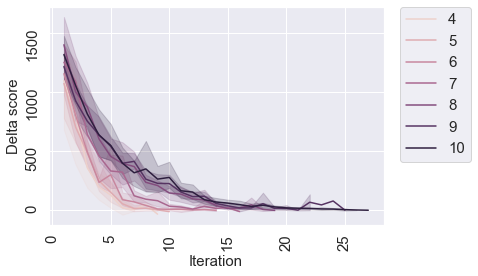

In [ ]:
sns.set(style="darkgrid")
sns.lineplot(x='Iteration', y = 'Delta score', hue='Number nodes', data =metrics_df)
plt.ylabel('Delta score', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.tick_params(labelsize=15, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.savefig("Shod.pdf", format="pdf", bbox_inches="tight", facecolor='w')

In [ ]:
metrics_df.groupby(['Method', 'Number nodes'])['AR'].mean()

Method   Number nodes
Gauss    4               0.698000
         5               0.659200
         6               0.491600
         7               0.416400
         8               0.415600
         9               0.333333
         10              0.250500
K2       4               0.586000
         5               0.453200
         6               0.455200
         7               0.334800
         8               0.296000
         9               0.273333
         10              0.277500
Mixture  4               0.928800
         5               0.790400
         6               0.812800
         7               0.687200
         8               0.702000
         9               0.580000
         10              0.612000
Name: AR, dtype: float64

In [ ]:
x1 = [0.2, 0.2, 2, 2.7, 2.8, 3, 3]
y1 = [0.15, 0.24, 0.24, 0.17, 0.14, 0.16, 0.15]

x2 = [20, 30, 35, 45, 48, 51, 53]
y2 = [0.4, 0.34, 0.44, 0.4, 0.4, 0.32, 0.4]

x3 = [10, 12, 20, 22, 30, 32, 40]
y3 = [0.3, 0.2, 0.2, 0.2, 0.2, 0.2, 0.17]



x11 = [0.2, 0.2, 2, 2.7, 2.8, 3, 3]
y11 = [0.58, 0.45, 0.45, 0.33, 0.29, 0.27, 0.27]

x21 = [20, 30, 35, 45, 48, 51, 53]
y21 = [0.92, 0.8, 0.81, 0.7, 0.7, 0.6, 0.6]

x31 = [10, 12, 20, 22, 30, 32, 40]
y31 = [0.69, 0.65, 0.49, 0.41, 0.41, 0.33, 0.25]


z = [1, 2, 3, 4, 5, 6, 7]

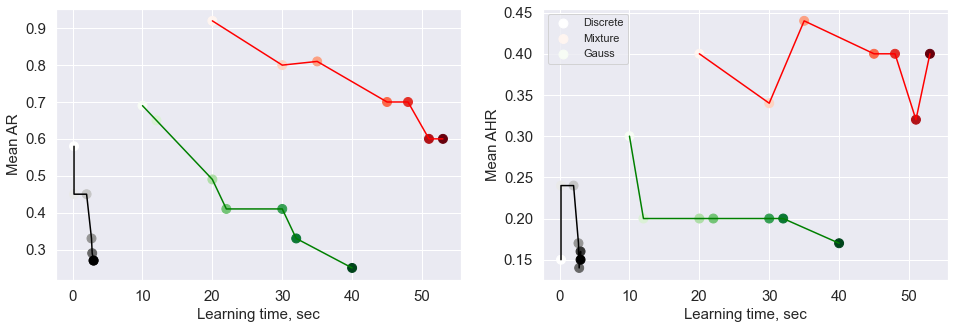

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))




ax[1].scatter(x1, y1, label='Discrete', c=z, cmap='Greys', s=80)
ax[1].plot(x1, y1, color='black')
ax[1].scatter(x2, y2, label='Mixture', c=z, cmap='Reds', s=80)
ax[1].plot(x2, y2, color='red')
ax[1].scatter(x3, y3, label='Gauss', c=z, cmap='Greens', s=80)
ax[1].plot(x3, y3, color='green')
ax[1].set_xlabel('Learning time, sec', fontsize=15)
ax[1].set_ylabel('Mean AHR', fontsize=15)
ax[1].tick_params(labelsize=15)



ax[0].scatter(x11, y11, label='Discrete', c=z, cmap='Greys', s=80)
ax[0].plot(x11, y11, color='black')
ax[0].scatter(x21, y21, label='Mixture', c=z, cmap='Reds', s=80)
ax[0].plot(x21, y21, color='red')
ax[0].scatter(x31, y31, label='Gauss', c=z, cmap='Greens', s=80)
ax[0].plot(x31, y31, color='green')
ax[0].set_xlabel('Learning time, sec', fontsize=15)
ax[0].set_ylabel('Mean AR', fontsize=15)
ax[0].tick_params(labelsize=15)
plt.savefig("time_all.pdf", format="pdf", bbox_inches="tight", facecolor='w')


In [ ]:

hack_data = pd.read_csv("../Data/daks_processed_with_rf_ntg.csv")[
    ['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth', 'Oil recovery factor']]

encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

p = Preprocessor([('encoder', encoder), ('discretizer', discretizer)])

discretized_data, est = p.apply(hack_data)
hack_data.dropna(inplace=True)
hack_data.reset_index(inplace=True, drop=True)

2022-04-08 20:39:47,218 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [ ]:
bn = Nets.ContinuousBN(use_mixture=True)
bn.add_nodes(p.info)
bn.add_edges(hack_data, scoring_function=('K2', BICGMM))

  0%|          | 9/1000000 [03:15<6047:35:13, 21.77s/it] 


In [ ]:
bn.fit_parameters(hack_data)

In [ ]:
sample1 = bn.sample(500)

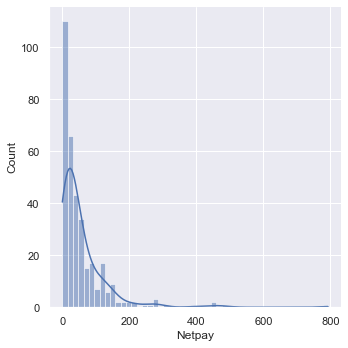

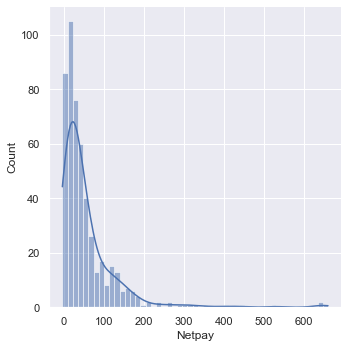

In [ ]:
sns.displot(hack_data['Netpay'], kde=True)
sns.displot(sample1['Netpay'], kde=True)

In [ ]:
df = pd.read_csv('../Data/final_sample_fact_processed.csv')
dates = df['Data'].values
df = df.drop(columns = ['Data'])
df_empty_column = []
for c in df.columns:
    if (df[c] == 0).all():
        df_empty_column.append(c)

df_empty_column = df_empty_column #+ ['технические ресурсы res']
columns = [c for c in df.columns.tolist() if c not in df_empty_column]
df = df[columns]


df = df.astype(float)

In [ ]:
map_act_res = {'Погружение свай_act_fact': ['Автобетоносмеситель_res_fact', 'Автокран_res_fact', 'Автомастерская_res_fact', 'Бензовоз_res_fact', 'Бетонщик_res_fact', 'Буровая установка_res_fact', 'Бурильная машина_res_fact', 'Водители_res_fact', 'Водовозка_res_fact', 'ИТР_res_fact', 'Копровщик_res_fact', 'Механизаторы_res_fact', 'Монтажник_res_fact', 'Подсобный рабочий_res_fact', 'Разнорабочий_res_fact', 'Стропальщик_res_fact', 'Топливозаправщик_res_fact', 'Экскаваторы_res_fact'],
'Бурение и погружение_act_fact':['Автобетоносмеситель_res_fact', 'Автокран_res_fact', 'Автомастерская_res_fact', 'Бензовоз_res_fact', 'Бетонщик_res_fact', 'Бурильная машина_res_fact', 'Буровая установка_res_fact', 'Водители_res_fact', 'Водовозка_res_fact', 'ИТР_res_fact', 'Копровщик_res_fact', 'Механизаторы_res_fact', 'Монтажник_res_fact', 'Подсобный рабочий_res_fact', 'Разнорабочий_res_fact', 'Стропальщик_res_fact', 'Топливозаправщик_res_fact', 'Экскаваторы_res_fact'],
'Изготовление и погружение свай_act_fact':['Автокран_res_fact', 'Автомастерская_res_fact', 'Бензовоз_res_fact', 'Водители_res_fact', 'Газорезчик_res_fact', 'ДЭС_res_fact', 'ИТР_res_fact', 'Механизаторы_res_fact', 'Стропальщик_res_fact', 'Топливозаправщик_res_fact', 'Электрики_res_fact', 'Электромонтажник_res_fact', 'Электросварщики_res_fact'],
'Устройство свайного основания_act_fact':['Автобетоносмеситель_res_fact', 'Автокран_res_fact', 'Автомастерская_res_fact', 'Автоцистерна_res_fact', 'Бензовоз_res_fact', 'Бетонщик_res_fact', 'Бурильная машина_res_fact', 'Буровая установка_res_fact', 'Водители_res_fact', 'Водовозка_res_fact', 'ИТР_res_fact', 'Механизаторы_res_fact', 'Стропальщик_res_fact', 'Топливозаправщик_res_fact', 'Экскаваторы_res_fact', 'Монтажник_res_fact', 'Подсобный рабочий_res_fact', 'Разнорабочий_res_fact'],
'Срезка свай_act_fact':['Газорезчик_res_fact', 'ИТР_res_fact', 'Монтажник_res_fact'],
'Монтаж оголовников свай_act_fact':['Автомастерская_res_fact', 'Бензовоз_res_fact', 'ДЭС_res_fact', 'ИТР_res_fact', 'Механизаторы_res_fact', 'Монтажник_res_fact', 'Топливозаправщик_res_fact', 'Электрики_res_fact', 'Электромонтажник_res_fact', 'Электросварщики_res_fact'],
'Надземная прокладка трубопровода_act_fact':['Автокран_res_fact', 'Автомастерская_res_fact', 'Антикоррозийщик_res_fact', 'Бензовоз_res_fact', 'ДЭС_res_fact', 'ИТР_res_fact', 'Механизаторы_res_fact', 'Монтажник_res_fact', 'ППУ_res_fact', 'Стропальщик_res_fact', 'Топливозаправщик_res_fact', 'Тягач с полуприцепом_res_fact', 'Электрики_res_fact', 'Электромонтажник_res_fact', 'Электросварщики_res_fact'],
'Сварка трубопровода_act_fact':['Автокран_res_fact', 'Автомастерская_res_fact', 'Бензовоз_res_fact', 'Водители_res_fact', 'ДЭС_res_fact', 'ИТР_res_fact', 'Механизаторы_res_fact', 'Монтажник_res_fact', 'Стропальщик_res_fact', 'Топливозаправщик_res_fact', 'Электрики_res_fact', 'Электромонтажник_res_fact', 'Электросварщики_res_fact'],
'Обратная засыпка_act_fact': ['Бульдозер_res_fact','Водители_res_fact', 'ИТР_res_fact', 'Механизаторы_res_fact', 'Подсобный рабочий_res_fact', 'Разнорабочий_res_fact', 'Экскаваторы_res_fact'],
'Прокладка кабеля_act_fact':['Автовышка_res_fact', 'Автокран_res_fact', 'Автомобиль_res_fact', 'Водители_res_fact', 'ИТР_res_fact', 'Механизаторы_res_fact', 'Электромонтажник_res_fact'],
'Монтаж лотков для кабеля_act_fact':['ИТР_res_fact', 'Электромонтажник_res_fact'],
'Устройство заземления_act_fact':['ДЭС_res_fact', 'ИТР_res_fact', 'Электромонтажник_res_fact'],
'Разработка грунта_act_fact':['Бульдозер_res_fact', 'Водители_res_fact', 'ИТР_res_fact', 'Механизаторы_res_fact', 'ППУ_res_fact', 'Подсобный рабочий_res_fact', 'Разнорабочий_res_fact', 'Самосвал_res_fact', 'Экскаваторы_res_fact']}

In [ ]:
static = ['Директор проекта_res_fact', 'Руководитель_res_fact', 'Повар_res_fact', 'Автомастерская_res_fact', 'Автобус_res_fact', 'Топливозаправщик_res_fact', 'Бензовоз_res_fact', 'Водовозка_res_fact', 'Вахтовый автомобиль_res_fact']
for key in map_act_res:
    new_res = []
    for r in map_act_res[key]:
        if r not in static:
            new_res.append(r)
    map_act_res[key] = new_res


In [ ]:
df = df.drop(columns=static)

In [ ]:

discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
p = Preprocessor([('discretizer', discretizer)])
discretized_data, est = p.apply(df)
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)



2022-04-11 15:56:28,495 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [ ]:
act = [c+'_act_fact' for c in ['Бурение и погружение', 'Изготовление и погружение свай', 'Монтаж оголовников свай', 'Надземная прокладка трубопровода',
    'Сварка трубопровода', 'Срезка свай', 'Устройство свайного основания', 'Погружение свай', 'Обратная засыпка', 'Прокладка кабеля', 'Монтаж лотков для кабеля', 'Устройство заземления', 'Разработка грунта']]

In [ ]:
res = [c for c in df.columns if c.split('_')[-2]=='res']

In [ ]:
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
p_res = Preprocessor([('discretizer', discretizer)])
discretized_data_res, est = p_res.apply(df[res])

2022-04-11 15:56:40,861 | INFO     | Preprocessors.py-scan-0091 | No one column is discrete


In [ ]:
mix_bn = Nets.ContinuousBN(use_mixture=True)
mix_bn.add_nodes(p_res.info)
mix_bn.add_edges(df[res], scoring_function=('K2', BICGMM))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
asia = pd.read_csv('asia.csv')
asia = asia.drop(columns=['Unnamed: 0'])
asia

,asia,tub,smoke,lung,bronc,either,xray,dysp
0,no,no,yes,no,no,no,yes,no
1,no,no,no,no,yes,no,no,yes
2,no,no,yes,no,no,no,no,no
3,no,no,no,no,no,no,no,no
4,no,no,no,no,no,no,yes,no
...,...,...,...,...,...,...,...,...
995,no,no,no,no,no,no,no,no
996,no,no,no,no,no,no,no,no
997,no,no,no,no,yes,no,no,yes
998,no,no,yes,no,yes,no,no,yes


In [ ]:
coder = preprocessing.LabelEncoder()
p = Preprocessor([('encoder', coder)])

coded_data, est = p.apply(asia)

2022-04-28 16:10:03,740 | INFO     | Preprocessors.py-scan-0087 | No one column is continuous


In [ ]:
structure = [('asia', 'xray'), ('tub', 'bronc'), ('smoke', 'asia'), ('lung', 'either'), ('lung', 'xray'), ('bronc', 'dysp'), ('either', 'smoke'), ('xray', 'tub'), ('xray', 'dysp')]
bn_asia = Nets.DiscreteBN()

bn_asia.add_nodes(p.info)

In [ ]:
bn_asia.set_structure(edges=structure)

In [ ]:
bn_asia.fit_parameters(asia)

In [ ]:
for c in asia.columns:
    test = asia.drop(columns=[c])
    bn_asia.predict(test)

100%|██████████| 1000/1000 [00:01<00:00, 606.79it/s]
